# Example 5: conjugation of thiophenes with arbitrary sidechains

## Output config

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Defining thiophenyl monomer with arbitrary sidechain

### "Choose your fighter!"
Here you can specify **ANY** sidechain for the thiophene monomer; the fragment enumeration and build steps which follow proceed without further modification  
This is the real power of the rules-based reaction approach; for a given polymerization mechanism, you only need "one template to rule them all"

Try out one of the pre-supplied sidechains, or write your own SMILES! If writing your own, take care to use 2 (not 1) when defining any ring closures

In [2]:
# sidechain_smiles = '[H]' # bare thiophene
# sidechain_smiles : str = 'CCCCCC'   # generic hexyl substituent (for poly(3-hexylthiophene) [P3HT])
# sidechain_smiles : str = 'c2ccccc2' # phenyl chain to show this works for aromatic groups
sidechain_smiles = 'C2=NNN=N2' # tetrazole ring, to show this works for less common groups too :)
# sidechain_smiles = '???' # try it yourself!

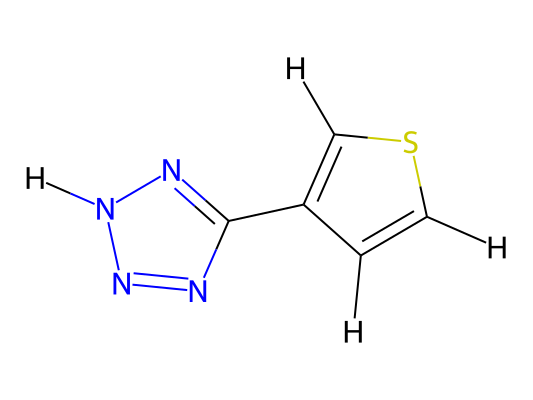

In [3]:
from rdkit.Chem.rdmolops import SANITIZE_ALL, AROMATICITY_MDL
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES

monomer_smiles = f's1cc({sidechain_smiles})cc1'
monomer = explicit_mol_from_SMILES(monomer_smiles, sanitize_ops=SANITIZE_ALL, aromaticity_model=AROMATICITY_MDL)
display(monomer)

### Determine proper IUPAC name for the thiophenyl monomer you've chosen
`polymerist` also exposes several chemical database APIs, including [PubChem's PugRest](https://iupac.github.io/WFChemCookbook/datasources/pubchem_pugrest.html) and the [NIH's CACTUS](https://cactus.nci.nih.gov/chemical/structure)  
One can use these to query chemical information for a given molecule from the web;  


For example here, the name of our custom thiophenyl residue should change with its identity;  
rather than selecting this by hand, we can look up the proper IUPAC name from a database, as one might need to do in a high-throughput application

In [4]:
from polymerist.smileslib.chemdbqueries import (
    get_chemical_property,
    NIHCACTUSQueryStrategy,
    PubChemQueryStrategy,
)

try:
    monomer_name = get_chemical_property(
        'iupac_name',
        monomer_smiles,
        namespace='smiles',
        services=[
            PubChemQueryStrategy(),
            NIHCACTUSQueryStrategy(), # NIH CACTUS seems to get taken offline fairly often, so we'll reserve it as a fallback for PubChem
        ]
    )
    polymer_name = f'poly({monomer_name})'
except:
    polymer_name = 'polythiophene' # fallback name if the IUPAC name cannot be retrieved
    
print(polymer_name)

INFO:polymerist.smileslib.chemdbqueries:Attempting chemical property query to service 1/2 ("PubChem"):
INFO:polymerist.smileslib.chemdbqueries:Sent query request for property "iupac_name" to PubChem
INFO:polymerist.smileslib.chemdbqueries:Successfully received property "iupac_name" from PubChem


poly(5-thiophen-3-yl-2H-tetrazole)


## Define polymerization reaction template based on active functional groups
This time, we _also_ include R-groups in our templates.   
These are represented with a linker too, since they represent an _a priori_ unknown collection of atoms neighboring the R-group bridgehead

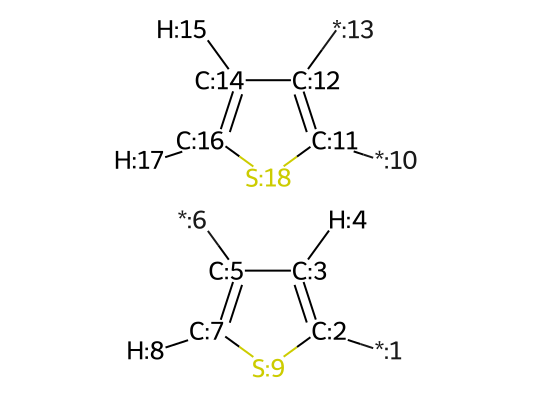

In [5]:
from rdkit.Chem.rdmolfiles import MolFromSmarts, MolFromSmiles
from polymerist.smileslib.cleanup import expanded_SMILES
from polymerist.rdutils.reactions.assembly import ReactionAssembler


assem = ReactionAssembler(
    reactive_groups=[ # use expanded_SMILES to fill in chemical detail for us (namely bond order and hydrogens)
        MolFromSmarts(expanded_SMILES('s1cc(*)cc1*', assign_map_nums=False)), 
        MolFromSmarts(expanded_SMILES('s1ccc(*)c1*', assign_map_nums=False)),
    ],
    byproducts=[
        MolFromSmarts('[H]-[H]') # H2 byproduct to eject during reaction
    ],
    rxn_name='thiophene conjugation',
)
display(assem.reactants)

INFO:polymerist.rdutils.bonding.permutation:8 --x-> 7


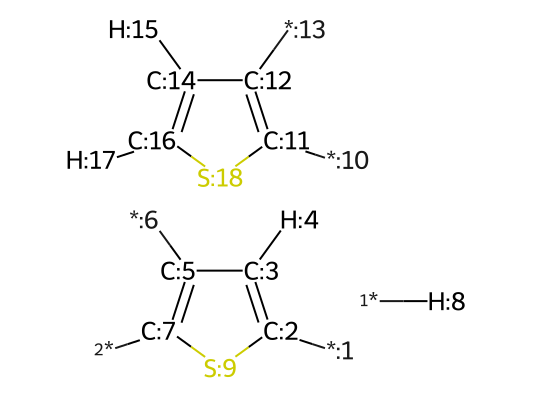

INFO:polymerist.rdutils.bonding.permutation:16 --x-> 17


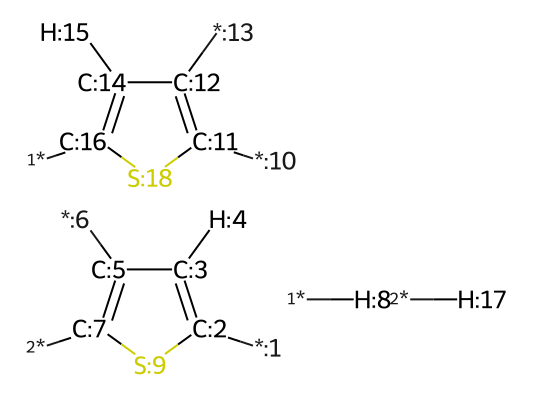

INFO:polymerist.rdutils.bonding.permutation:8 ----> 17


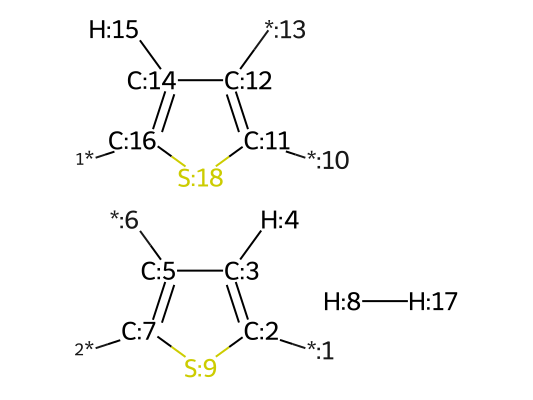

INFO:polymerist.rdutils.bonding.permutation:16 ----> 7


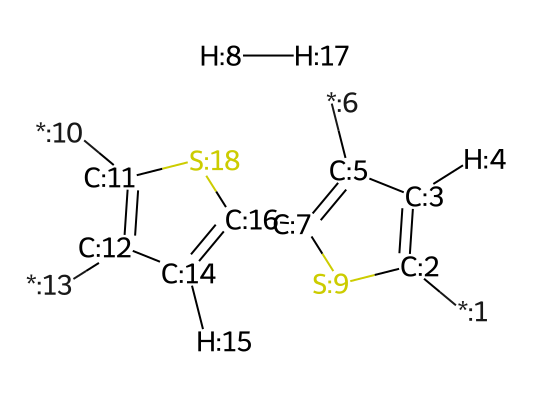

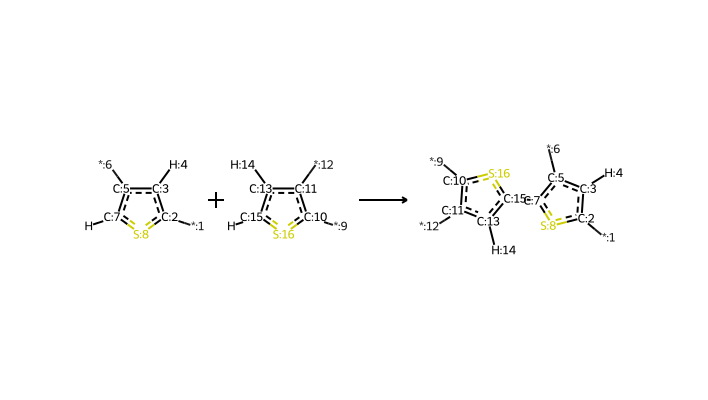

In [6]:
assem.bond_derangement = {
    8  : (7, 17), # H8 , which was connected to C7 , should reconnect to H17
    16 : (17, 7), # C16, which was connected to H17, should reconnect to C7
}

rxn = assem.assemble_rxn(show_steps=True)
rxn_smarts = rxn.to_smarts()
display(rxn)

### Export reaction for re-use

In [7]:
from polymerist.genutils.fileutils import assemble_path


rxn_smarts = rxn.to_smarts()
rxn_path = assemble_path('rxn_demo_files/rxns', prefix=rxn.rxnname, extension='rxn')
rxn_path.parent.mkdir(exist_ok=True, parents=True)
rxn.to_rxnfile(rxn_path)

## Enumerate all possible repeat unit fragments from monomers and reaction template

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 1 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


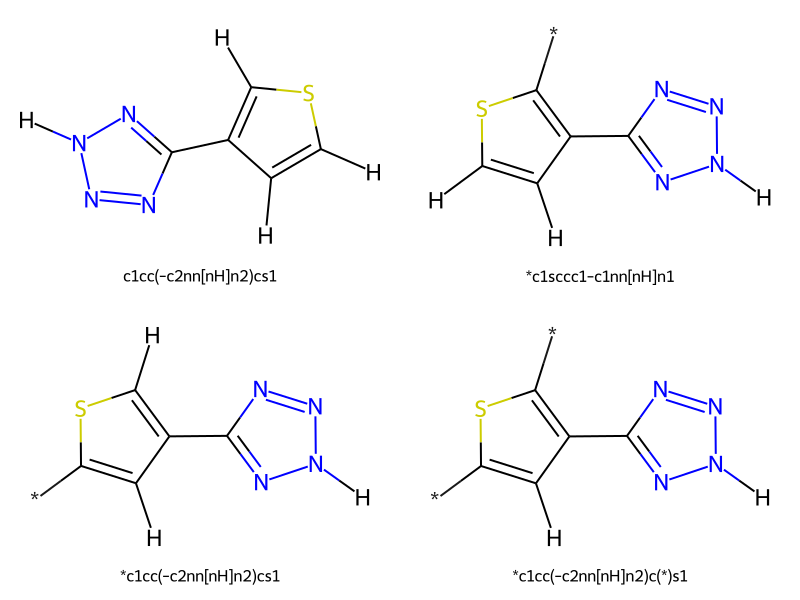

In [8]:
from polymerist.rdutils.reactions import AnnotatedReaction
from polymerist.rdutils.reactions import PolymerizationReactor, CutMinimumCostBondsStrategy


reactor = PolymerizationReactor(
    rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts),
    fragment_strategy=CutMinimumCostBondsStrategy()
)
fragments = reactor.propagate_pooled(
    [monomer],
    allow_resampling=True, # rather than defining two identical copies of the monomer, we can simply allow it to interact with itself
    sanitize_ops=SANITIZE_ALL,
    aromaticity_model=AROMATICITY_MDL,
    clear_dummy_labels=True,
)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=list(fragments.keys()))

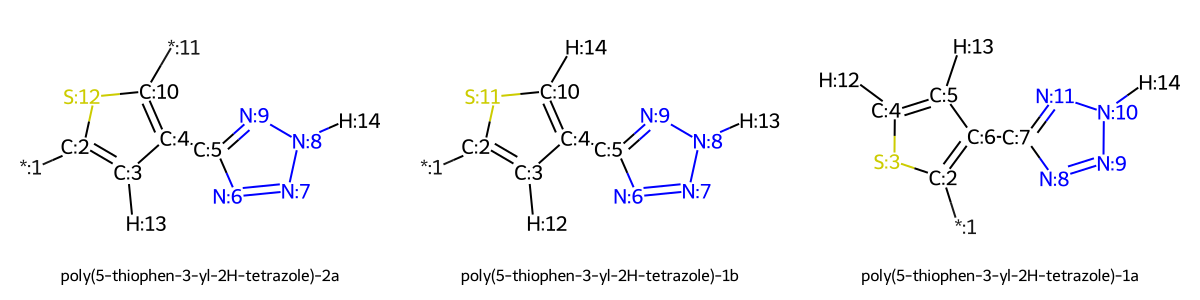

In [9]:
from string import ascii_lowercase
from collections import defaultdict, Counter

from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports
from polymerist.genutils.iteration import sort_dict_by_keys


named_fragments : dict[str, str] = {}
fragment_name_modifiers = defaultdict(Counter) # keeps track of how many times each (monomer name, functionality) pair is found to generate distinguishing suffixes
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    query_mol = MolFromSmarts(canon_smiles) # important! need to makes SMARTS-based query mol to check for substructure - ports on returned SMILES-based mols are not treated correctly as wild-type atoms
    suffix = ascii_lowercase[fragment_name_modifiers[polymer_name][functionality]]
    
    named_fragments[f'{polymer_name}-{functionality}{suffix}'] = canon_smiles
    fragment_name_modifiers[polymer_name][functionality] += 1
    
monogrp = MonomerGroup(sort_dict_by_keys(named_fragments, reverse=True)) # sorting is not necessary for any functionality, but groups like fragments together for viewing 
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=list(monogrp.monomers.keys()))

## Building a polymer structure with arbitrarily many repeat units and saving to a PDB file

In [ ]:
from polymerist.polymers.building import build_linear_polymer


# these are for you to configure
n_monomers : int = 100
do_energy_min : bool = False # if enable, will yield more physically-plausible structure, at the cost of slower structure output

monogrp.term_orient = {
    'head' : f'{polymer_name}-1a',
    'tail' : f'{polymer_name}-1b',
}
chain = build_linear_polymer(
    monomers=monogrp,
    n_monomers=n_monomers,
    sequence='B', # described sequence unit of middle monomers AFTER the initial A head group
    energy_minimize=do_energy_min,
)
chain.visualize()

[16:28:31] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'poly(5-thiophen-3-yl-2H-tetrazole)-1a', 'tail': 'poly(5-thiophen-3-yl-2H-tetrazole)-1b'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "B" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 98 whole 1-sequence repeat(s), namely with the sequence [poly(5-thiophen-3-yl-2H-tetrazole)-1a] + 98*[B] + [poly(5-thiophen-3-yl-2H-tetrazole)-1b]
INFO:polymerist.polymers.building.linear:Registering middle monomer poly(5-thiophen-3-yl-2H-tetrazole)-2a (block identifier "B")
INFO:polymerist.polymers.building.linear:Registering terminal monomer poly(5-thiophen-3-yl-2H-tetrazole)-1a (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer poly(5-thiophen-3-yl-2H-tetrazole)-1b (orientation "tail")
INFO:polymerist.polymers.

## Export polymer structure files

In [ ]:
from pathlib import Path


structures_dir = Path('rxn_demo_files/structures') / polymer_name
structures_dir.mkdir(exist_ok=True, parents=True)

### Export to SDFile

In [ ]:
from rdkit.Chem.rdmolfiles import SDWriter
from polymerist.polymers.building import mbmol_to_rdmol


sdf_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='sdf')
with SDWriter(sdf_path) as writer:
    writer.write(mbmol_to_rdmol(chain))

### Export to PDB File

In [ ]:
from polymerist.polymers.building import mbmol_to_openmm_pdb


pdb_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='pdb')
pdb_path.parent.mkdir(exist_ok=True, parents=True)
mbmol_to_openmm_pdb(pdb_path, chain)

### Save repeat unit fragments to disc

In [ ]:
fragments_path = assemble_path('rxn_demo_files/fragments', prefix=polymer_name, extension='json')
fragments_path.parent.mkdir(exist_ok=True, parents=True)
monogrp.to_file(fragments_path)